In [41]:
import random
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from datetime import datetime,date,timedelta
pd.set_option('display.max_rows',None)
import sys
import warnings
import calendar
import time
import mibian
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from scipy.spatial.distance import euclidean
from statsmodels.api import OLS
from statsmodels.tsa.stattools import adfuller

if not sys.warnoptions:
    warnings.simplefilter("ignore")
from time import sleep
from tqdm import tqdm
from tqdm.notebook import tqdm
from zipfile import ZipFile
import os 

In [38]:
def clean_data(asset,roll):
    df = pd.read_excel("Gold Silver Ratio.xlsx",sheet_name=asset)
    df['DTE'] = df['Expiry date'] - df['As on date']
    df= df.loc[:,['As on date','Expiry date','Close','OI','Expiry Month Ser No','DTE']]
    df0 = df[df['Expiry Month Ser No']==0]
    df1 = df[df['Expiry Month Ser No']==1]
    df_merge = df0.merge(df1 ,how='outer',on='As on date')
    
    data = pd.DataFrame(columns=['Date','Expiry','Price','DTE'])
    
    for i in range(len(df_merge)):
        date = df_merge['As on date'].iloc[i]
        if df_merge['DTE_x'].iloc[i].days<roll:
            exp = df_merge['Expiry date_y'].iloc[i]
            pr = df_merge['Close_y'].iloc[i]
            dte = df_merge['DTE_y'].iloc[i]
        else:
            exp = df_merge['Expiry date_x'].iloc[i]
            pr = df_merge['Close_x'].iloc[i]
            dte = df_merge['DTE_x'].iloc[i]
        dicts = [{'Date':date,'Expiry':exp,'Price':pr,'DTE':dte}]
        data  =data.append(dicts,ignore_index=True, sort=False)
    return (data)


def merge_and_adjust(base,other,perc):
    df = base.merge(other,how='inner',on='Date')
    df['delta dte'] = df['DTE']=df['DTE_y']-df['DTE_x']
    df['X'] = df['Price_x']
    df['Y']= 0
    for i in range(len(df)):
        del_days = df['delta dte'].iloc[i].days
        if del_days>0:
            d_factor = 1/(pow((1+perc/100),(del_days/365)))
        elif del_days<0:
            d_factor = (pow((1+perc/100),(-del_days/365)))
        else:
            d_factor = 1

        df['Y'].iloc[i]= round(df['Price_y'].iloc[i]*d_factor,0)
    df['Ratio'] = df['Y']/df['X']
    return df

In [35]:
roll_days = 7
gold_clean = clean_data("GOLD",roll_days)
silver_clean  =clean_data("SILVER",roll_days)
df = merge_and_adjust(gold_clean,silver_clean,6)
df = df.set_index('Date')

In [130]:
def adftest(spread):
    adf = adfuller(spread,autolag='BIC')
    #print(spread)
    print("Start date: ", spread.index[0].date())
    print("End date: ",spread.index[-1].date())
    print('t-stat = ', round(adf[0],2))
    print('p-value = ', round(adf[1],2))
    if adf[1]<0.30:
        group = "Mean-reverting"
    elif adf[1]>0.70:
        group = "Trending"
    else:
        group = "No-Result"
    print(group)
    print(adf[4])
        
    
def hurst_exp(time_series,max_lag=20):
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    print("Hurst Exp: ",round(reg[0],2))
    if reg[0]>0.7:
        group = "Trending"
    elif reg[0]<0.3:
        group ="Mean-reverting"
    else:
        group ="No-Result"
    
    print(group)
    return group
    

In [131]:
adftest(df['Ratio'])

Start date:  2010-01-01
End date:  2022-11-24
t-stat =  -1.57
p-value =  0.5
No-Result
{'1%': -3.432336161366224, '5%': -2.8624175686388993, '10%': -2.567237147952593}


In [128]:
lag=100
h= hurst_exp(df['Ratio'].values,lag)


Hurst Exp:  0.5
No-Result


In [129]:
df.head()

,Expiry_x,Price_x,DTE_x,Expiry_y,Price_y,DTE_y,delta dte,DTE,X,Y,Ratio
Date,,,,,,,,,,,
2010-01-01,2010-02-05,16686,35 days,2010-03-05,26740,63 days,28 days,28 days,16686,26621,1.59541
2010-01-04,2010-02-05,16830,32 days,2010-03-05,27245,60 days,28 days,28 days,16830,27123,1.61159
2010-01-05,2010-02-05,16833,31 days,2010-03-05,27638,59 days,28 days,28 days,16833,27515,1.63459
2010-01-06,2010-02-05,16865,30 days,2010-03-05,27813,58 days,28 days,28 days,16865,27689,1.6418
2010-01-07,2010-02-05,16827,29 days,2010-03-05,27960,57 days,28 days,28 days,16827,27835,1.65419


<AxesSubplot:xlabel='Date'>

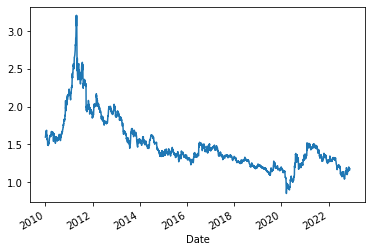

In [59]:
df['Ratio'].plot()

In [58]:
df.to_excel("Sample_data_version_1.xlsx")